# 5 Урок: A/В-тесты

---

## Задание №2: Проведение A/B-теста

> **Описание:** 
>
> Пришло время **проанализировать результаты эксперимента**, который мы провели вместе с командой дата сайентистов. Эксперимент **проходил с 2023-01-31 по 2023-02-06 
> включительно**. Для эксперимента были задействованы 2 и 1 группы. 
> 
> **В группе 2** был использован **один из новых алгоритмов** рекомендации постов, **группа 1 использовалась в качестве контроля**. 
> 
> Основная гипотеза заключается в том, что **новый алгоритм во 2-й группе приведет к увеличению CTR**. 


>**Задача:**
>
>проанализировать данные АB-теста, самостоятельнно выбрать метод анализа и сравнить CTR в двух группах.



---
## Установим необходимые библиотеки и подключение к БД

In [1]:
# установим необходимые библиотеки

import pandas as pd
import numpy as np
import pandahouse as ph
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# установим фиксированные размер для будущих графиков

sns.set(rc={'figure.figsize':(12,9)})

In [3]:
# установим соединение с БД

con = {
    'host': '*****',
    'password': '*****',
    'user': '*****',
    'database': '*****'
}

## Напишем запрос и вытащим наши данные

In [4]:
## напишем запрос

query = '''

SELECT exp_group,
       user_id,
       sum(action = 'view') AS view,
       sum(action = 'like') AS like,
       like / view AS ctr
FROM simulator_20230220.feed_actions       
WHERE (toDate(time) >= '2022-01-31' AND toDate(time) <='2023-02-06')
      AND exp_group IN (1,2)
GROUP BY exp_group, user_id


'''

In [5]:
# поместим данные в переменную df

df = ph.read_clickhouse(query, connection=con)

In [6]:
# выведем на экран

df.head()

,exp_group,user_id,view,like,ctr
0,1,109963,272,42,0.154412
1,1,26117,176,45,0.255682
2,1,138232,73,18,0.246575
3,1,26295,131,37,0.282443
4,1,18392,134,25,0.186567


In [7]:
# сравник количество участников

df.groupby('exp_group').count()

,user_id,view,like,ctr
exp_group,,,,
1,13123,13123,13123,13123
2,12987,12987,12987,12987


Группы примерно равны

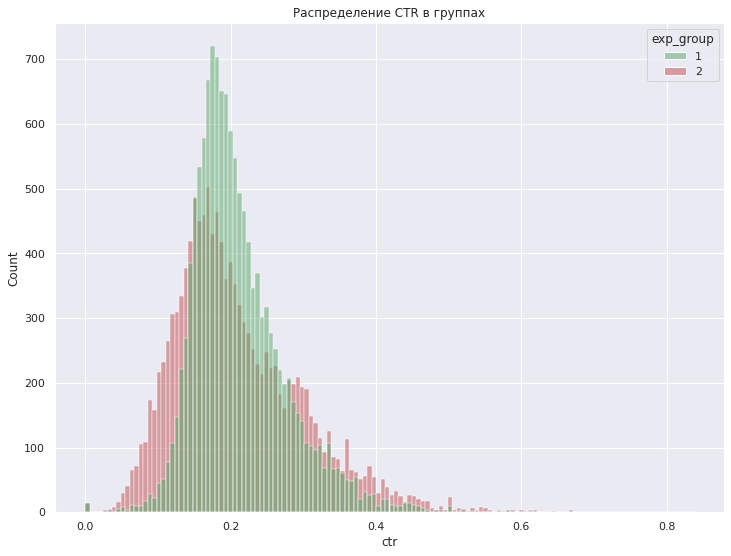

In [8]:
# посмотрим на распределение CTR в наших данных

groups = sns.histplot(data=df,
                      x='ctr', 
                      hue='exp_group', 
                      alpha=.5, 
                      palette=['g', 'r'])

groups.set_title('Распределение CTR в группах');

In [9]:
# посмотрим на средний CTR в группах

df[df.exp_group == 1]['ctr'].mean(), df[df.exp_group == 2]['ctr'].mean()

(0.21184502749296094, 0.2103767965344893)

Мы видим, что наши распределения смещены относительно друг друга, а так же на графике видны выбросы.

## Проверим данные T-тестом


**Гипотеза:**

**Нулевая гипотеза** H0: μ1=μ2

**Альтернативная гипотеза** H1: μ1 != μ2


In [10]:
# возьмем альфа в 5%

alpha = 0.05

result = st.ttest_ind(df[df.exp_group == 1]['ctr'], df[df.exp_group == 2]['ctr'], equal_var=False)

if result.pvalue > alpha:
    print('Не получилост отвергнуть нулевую гипотезу. Мы не обнаружили статистически значимую разницу. ')
else:
    print('Отвергаем нулевую гипотезу. Между данными есть статистически значимая разница')
    
print(result)


Не получилост отвергнуть нулевую гипотезу. Мы не обнаружили статистически значимую разницу. 
Ttest_indResult(statistic=1.4985058750933717, pvalue=0.13401523012431005)


Думаю, что результаты t-теста не стоит расматривать как достоверные. В наших данных, как мы могли ранее наблюдать, есть скошенность в положительную сторону. Причиной могут быть выбросы, которые могут негативно влиять на результаты теста.


## Проверим данные тестом Манна-Уитни

**Нулевая гипотеза:** P(X>Y)=P(Y>X) или P(X>Y)=P(Y>X)

**Альтернативная гипотеза:** P(X>Y) != P(Y>X) или P(X>Y) != P(Y>X)

In [11]:
# альфа таже
# запустим тест

result = st.mannwhitneyu(df[df.exp_group == 1]['ctr'], df[df.exp_group == 2]['ctr'])

if result.pvalue > alpha:
    print('Не получилост отвергнуть нулевую гипотезу. Мы не обнаружили статистически значимую разницу. ')
else:
    print('Отвергаем нулевую гипотезу. Между данными есть статистически значимая разница')
    
print(result)


Отвергаем нулевую гипотезу. Между данными есть статистически значимая разница
MannwhitneyuResult(statistic=91250068.0, pvalue=3.702830712404751e-23)


In [12]:
# давайте на всякий случай, из-за сложности формулировки в нулевой гипотезе проверим наш тест

# согласно нулевой гипотезе, веротность того, что CTR из выборки 1 в 50% случаев будет больше CTR из выборки 2
A_B_groups = 0

for _ in range(10000):
    A_B_groups += df[df.exp_group == 1]['ctr'].sample().values[0] > df[df.exp_group == 2]['ctr'].sample().values[0]

In [13]:

print(f'В {A_B_groups/100}% случаев 1 группа > 2 группы. Должно быть 50%')    

В 53.38% случаев 1 группа > 2 группы. Должно быть 50%


## Непараметрический бутстреп

In [14]:
# напишем функцию для расчета глобального CTR в группах

def bootstrap(likes1, views1, likes2, views2, n_bootstrap=5000):

    poisson_bootstraps1 = st.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = st.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [15]:
# расчитаем глобальный CTR

likes1 = df[df.exp_group == 1].like.to_numpy()
views1 = df[df.exp_group == 1].view.to_numpy()
likes2 = df[df.exp_group == 2].like.to_numpy()
views2 = df[df.exp_group == 2].view.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

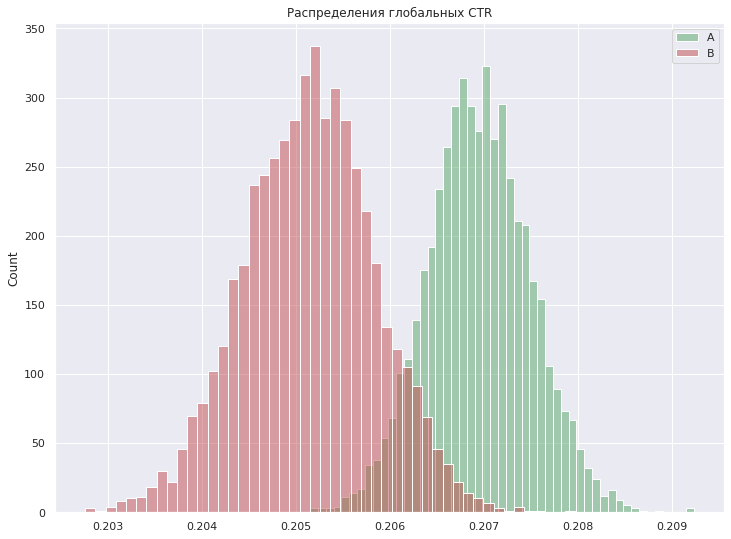

In [16]:
# посмотрим на распределение

sns.histplot(ctr1, color='g', alpha=.5)
sns.histplot(ctr2, color='r', alpha=.5)
plt.title('Распределения глобальных CTR')
plt.legend(['A', 'B'])
plt.show();

Видим, что наши распределения глобальных CTR чуть смещенны относительно друг друга.

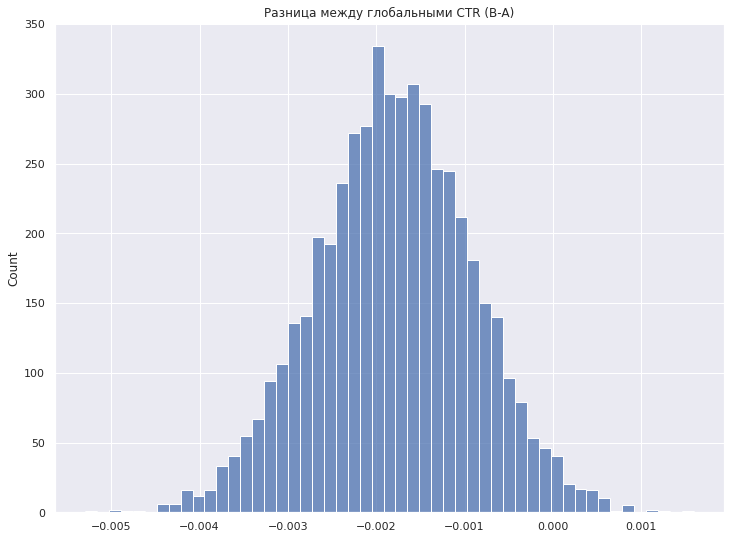

In [17]:
#Разница между глобальными CTR

plt.title('Разница между глобальными CTR (B-A)')
sns.histplot(ctr2 - ctr1);

Глобальный CTR в группе В меньше чем в группе А.

In [22]:
# проведем Т-тест

result = st.ttest_ind(ctr1, ctr2, equal_var=False)

if result.pvalue > alpha:
    print('Не получилост отвергнуть нулевую гипотезу. Мы не обнаружили статистически значимую разницу. ')
else:
    print('Отвергаем нулевую гипотезу. Между данными есть статистически значимая разница')
    
print(result)

Отвергаем нулевую гипотезу. Между данными есть статистически значимая разница
Ttest_indResult(statistic=144.42180766636645, pvalue=0.0)


In [23]:
# запустим тест Манна-Уитни

result = st.mannwhitneyu(ctr1, ctr2)

if result.pvalue > alpha:
    print('Не получилост отвергнуть нулевую гипотезу. Мы не обнаружили статистически значимую разницу. ')
else:
    print('Отвергаем нулевую гипотезу. Между данными есть статистически значимая разница')
    
print(result)

Отвергаем нулевую гипотезу. Между данными есть статистически значимая разница
MannwhitneyuResult(statistic=24506377.0, pvalue=0.0)


In [25]:
# давайте на всякий случай, из-за сложности формулировки в нулевой гипотезе проверим наш тест

# согласно нулевой гипотезе, веротность того, что CTR из выборки 1 в 50% случаев будет больше CTR из выборки 2
A_B_groups = 0

for _ in range(10000):
    A_B_groups += np.random.choice(ctr1) > np.random.choice(ctr2)

In [27]:
# подсчитаем наши значения

print(f'В {A_B_groups/100}% случаев 1 группа > 2 группы. Должно быть 50%')  

В 97.85% случаев 1 группа > 2 группы. Должно быть 50%


## Вывод

Мы провели три статистических теста и вот резуьтат:
 - **t-тест** не нашел статистически значимую разницу между нашими данными, но его результаты поддаются сомнению, поскольку он расчитывает средние наших выборок, а на графике мы могли видеть, что наши распределению отнють не нормальны. В них присутствуют выбросы, которые могут негативно повлиять на результаты теста;
 - Основываясь на том, что наши данные распределенны не нормально, мы решили провести другой тест - а именно **теста Манаа-Уитни**, который на наш взгляд более подходит для данной ситуации. Результаты теста показали, что между данными есть статистически значимая разница и очень низкий p-value. Но здесь нам смутило, то, что очень сложно сформулировать нулевую гипотезу, которая утверждает, что если взять случайную величину из группы А и случайную величину из группы В, то вероятность, что значение из группы А будет больше, чем в группе В --> и наоборот. Основываясь на формулировки гипотезы, мы случайно взяли из наших выборок 10000 значений и сравнили их и получили, что в 53% А > В. И вот тут закроилось сомнение, ведь 53% не так уж много на первый взгля. Поэтому мы решили провести третий тест;
 - третим тестом мы выбрали **Непараметрический бутсреп** в котором **сравнили групповой CTR t-тестом и тестом Манна-Уитни** где оба теста показали **p-value=0** и где оба теста соответственно отвергли нулевую гипотезу. Более того, сравнивая случайно взятые величины из двух подгрупп, В **97.85% случаев А группа > В группы**.


## Результаты АВ-теста

Мы провели несколько статистических тестов и выявили, что среди наших групп есть статистически значимая разница:
> **общегрупповой CTR в целевой группе стал хуже чем в контрольной группе. Вследствии чего я бы не рекомендовал раскатывать данный алгоритм на всех новых пользователей.**